# AWS DeepRacer Reward Function Attempt #

By Patrick Devane

Created 18/05/22

Made as part of Vista AWS DeepRacer Team 2Fast2Furious 2022

## Useful Links ##

- https://github.com/aws-deepracer-community/deepracer-analysis/tree/master/tracks
- https://github.com/aws-deepracer-community/deepracer-simapp/tree/master/bundle/deepracer_simulation_environment/share/deepracer_simulation_environment/routes
- https://github.com/aws-deepracer-community/deepracer-simapp
- https://github.com/cdthompson/deepracer-k1999-race-lines

## Hypothesis ##

A car that follows the center line is safe, but we want a car to take an inside line through a corner to improve speed.

Such a car must know the next `n` waypoints ahead and be rewarded for taking a more direct line.

## Limitations ##

The car should not attempt to cut across a corner that is too sharp, as doing so may cause it to leave the track. Therefore corners that are < 90 degrees are suitable.

# Car position relative to next and previous waypoint #

In [43]:
import math

# Create a list of waypoint points
point_list = [[0,0], [0.5,0], [1,0], [1,0.5], [1,1], [0,1]]

# Pick the points on either side of the car location
car_waypooint_idx = 0
prev_point = point_list[car_waypooint_idx]
next_point = point_list[car_waypooint_idx + 1]

# CAR VARIABLES
car_pos = [(next_point[0] + prev_point[0]) / 2, (next_point[1] - prev_point[1]) / 2] # Car location (x,y)
car_heading = 45 # Direction of the car relative to the x-axis (+ve only) in degrees
car_heading_vector = [0.1, math.tan(car_heading) * 0.1]

# Calculate the direction in radius, arctan2(dy, dx), the result is (-pi, pi) in radians
track_direction = math.atan2(next_point[1] - prev_point[1], next_point[0] - prev_point[0])
# Convert to degree
track_direction = math.degrees(track_direction)

# Calculate the difference between the track direction and the heading direction of the car
direction_diff = car_heading - track_direction
if direction_diff > 180:
    direction_diff = -(360 - direction_diff)

# Print the current diference between the car heading and the track direction
print(direction_diff)

45.0


# Finding the next corner ahead #

This is done with multiple assumptions. Mainly that the heading of the track underneath the car will deviate at a point in the future. The magnitude of this deviation will determine the approximate size of the corner approaching.

By approximating every segment as a straight line joining two waypoints, this removes the need to calculate the tangent vector at the waypoint positions.

In [44]:
# The direction of the track absed on the prev and next closest waypoints:
print(track_direction)

def calculate_track_direction(point_initial, point_final):
    # Calculate the direction in radius, arctan2(dy, dx), the result is (-pi, pi) in radians
    track_direction = math.atan2(point_final[1] - point_initial[1], point_final[0] - point_initial[0])
    # Convert to degrees
    track_direction = math.degrees(track_direction)
    return track_direction
    
for i in range(len(point_list)):
    initial_idx = (car_waypooint_idx + 1 + i) % len(point_list)
    final_idx = (car_waypooint_idx + 2 + i) % len(point_list)
    point_initial = point_list[initial_idx]
    point_final = point_list[final_idx]
    segment_direction = calculate_track_direction(point_initial, point_final)
    direction_change = track_direction - segment_direction
    if direction_change != 0:
        waypoints_ahead = i + 1
        break

# Output the next change in direction from the current position.
# -ve value means left hand turn, +ve value means right hand turn.
print(direction_change)
print(waypoints_ahead)

0.0
-90.0
2


# Plotting the Car and Track #

Using the position of the car and heading as a rough guide to show where the car is relative to points on the track

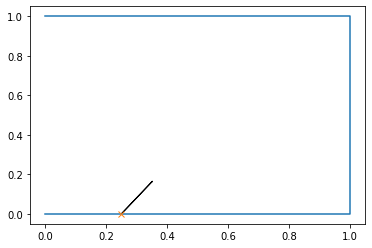

In [45]:
import matplotlib.pyplot as plt
plt.close("all")

x = [point[0] for point in point_list]
y = [point[1] for point in point_list]

plt.plot(x, y)
plt.plot(car_pos[0], car_pos[1], 'x')
plt.arrow(car_pos[0], car_pos[1],car_heading_vector[0],car_heading_vector[1])

# Using Catmull-Rom Spline Modelling #

0


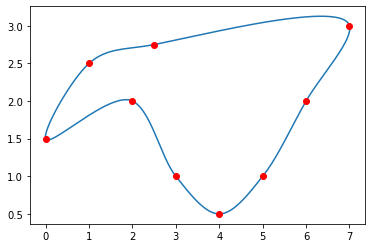

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def CatmullRomSpline(P0, P1, P2, P3, nPoints=100):
    """
    P0, P1, P2, and P3 should be (x,y) point pairs that define the Catmull-Rom spline.
    nPoints is the number of points to include in this curve segment.
    """
    # Convert the points to numpy so that we can do array multiplication
    P0, P1, P2, P3 = map(np.array, [P0, P1, P2, P3])

    # Parametric constant: 0.5 for the centripetal spline, 0.0 for the uniform spline, 1.0 for the chordal spline.
    alpha = 0.5
    # Premultiplied power constant for the following tj() function.
    alpha = alpha/2
    def tj(ti, Pi, Pj):
        xi, yi = Pi
        xj, yj = Pj
        return ((xj-xi)**2 + (yj-yi)**2)**alpha + ti

    # Calculate t0 to t4
    t0 = 0
    t1 = tj(t0, P0, P1)
    t2 = tj(t1, P1, P2)
    t3 = tj(t2, P2, P3)

    # Only calculate points between P1 and P2
    t = np.linspace(t1, t2, nPoints)

    # Reshape so that we can multiply by the points P0 to P3
    # and get a point for each value of t.
    t = t.reshape(len(t), 1)

    A1 = (t1-t)/(t1-t0)*P0 + (t-t0)/(t1-t0)*P1
    A2 = (t2-t)/(t2-t1)*P1 + (t-t1)/(t2-t1)*P2
    A3 = (t3-t)/(t3-t2)*P2 + (t-t2)/(t3-t2)*P3

    B1 = (t2-t)/(t2-t0)*A1 + (t-t0)/(t2-t0)*A2
    B2 = (t3-t)/(t3-t1)*A2 + (t-t1)/(t3-t1)*A3

    C = (t2-t)/(t2-t1)*B1 + (t-t1)/(t2-t1)*B2
    return C

def CatmullRomChain(P):
    """
    Calculate Catmull-Rom for a chain of points and return the combined curve.
    """
    sz = len(P)

    # The curve C will contain an array of (x, y) points.
    C = []
    for i in range(sz):   #range(sz-3):
        p0, p1, p2, p3 = i % sz, (i+1) % sz, (i+2) % sz, (i+3) % sz
        c = CatmullRomSpline(P[p0], P[p1], P[p2], P[p3])
        C.extend(c)

    return C

def CatmullRomCurve_GetTangent(curve, t):
    eps = 0.001
    return 1#normalize(CatmullRomCurve_GetPoint(curve, t + eps) - CatmullRomCurve_GetPoint(curve, t - eps));

"""
def CatmullRomCurve_GetNormal(CatmullRomCurve curve, float t) {
    vec2 tangent = CatmullRomCurve_GetTangent(curve, t);
    return vec2(-tangent.y, tangent.x);
}
"""

# Define a set of points for curve to go through
Points = [[0, 1.5], [2, 2], [3, 1], [4, 0.5], [5, 1], [6, 2], [7, 3], [2.5, 2.75], [1, 2.5]]
#Points = [[2, 3], [0, 1], [1, 1], [2, 2]]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #return array[idx]
    return idx

# Calculate the Catmull-Rom splines through the points
c = CatmullRomChain(Points)
#print(c[1])
#print(Points.index([2, 2]))
#print(np.all(c == [2, 2]))
print(find_nearest(c, [2,2]))

# Convert the Catmull-Rom curve points into x and y arrays and plot
x, y = zip(*c)
plt.plot(x, y)

# Plot the control points
px, py = zip(*Points)
plt.plot(px, py, 'or')

plt.show()

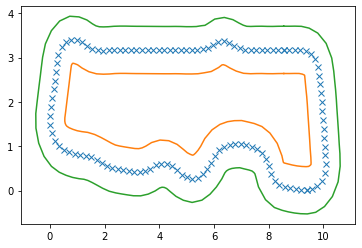

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#data_array = np.load('2022_may_open.npy')
data_array = np.load('2022_summit_speedway.npy')
data = pd.DataFrame(data_array)

plt.plot(data[0], data[1], 'x')
plt.plot(data[2], data[3])
plt.plot(data[4], data[5])
plt.show()

C:\Users\Patrick\AppData\Local\Temp/ipykernel_28688/1471472462.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  A3 = ( t3-t )/( t3-t2 )*curve.p2 + ( t-t2 )/( t3-t2 )*curve.p3
C:\Users\Patrick\AppData\Local\Temp/ipykernel_28688/1471472462.py:25: RuntimeWarning: invalid value encountered in add
  A3 = ( t3-t )/( t3-t2 )*curve.p2 + ( t-t2 )/( t3-t2 )*curve.p3
C:\Users\Patrick\AppData\Local\Temp/ipykernel_28688/1471472462.py:24: RuntimeWarning: invalid value encountered in double_scalars
  A2 = ( t2-t )/( t2-t1 )*curve.p1 + ( t-t1 )/( t2-t1 )*curve.p2
C:\Users\Patrick\AppData\Local\Temp/ipykernel_28688/1471472462.py:28: RuntimeWarning: invalid value encountered in double_scalars
  C  = ( t2-t )/( t2-t1 )*B1 + ( t-t1 )/( t2-t1 )*B2
C:\Users\Patrick\AppData\Local\Temp/ipykernel_28688/1471472462.py:23: RuntimeWarning: invalid value encountered in double_scalars
  A1 = ( t1-t )/( t1-t0 )*curve.p0 + ( t-t0 )/( t1-t0 )*curve.p1
C:\Users\Patrick\AppData\Local\Temp/ipykernel_2

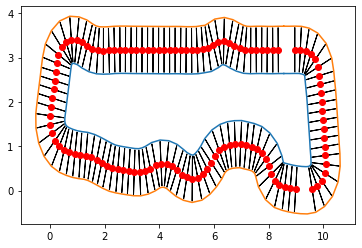

In [122]:
import numpy as np

class CatmullRomCurve:
    def __init__(self, p0, p1, p2, p3, alpha):
        self.p0 = p0
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.alpha = alpha

def GetT( t, alpha, p0, p1 ):
    d  = np.subtract(p1, p0)
    a = np.dot(d, d) # Dot product
    b = a ** (alpha*.5)
    return (b + t)

def CatmullRomCurve_GetPoint(curve, t):
    t0 = 0.0
    t1 = GetT( t0, curve.alpha, curve.p0, curve.p1 )
    t2 = GetT( t1, curve.alpha, curve.p1, curve.p2 )
    t3 = GetT( t2, curve.alpha, curve.p2, curve.p3 )
    t = t1 + (t2 - t1) * t
    A1 = ( t1-t )/( t1-t0 )*curve.p0 + ( t-t0 )/( t1-t0 )*curve.p1
    A2 = ( t2-t )/( t2-t1 )*curve.p1 + ( t-t1 )/( t2-t1 )*curve.p2
    A3 = ( t3-t )/( t3-t2 )*curve.p2 + ( t-t2 )/( t3-t2 )*curve.p3
    B1 = ( t2-t )/( t2-t0 )*A1 + ( t-t0 )/( t2-t0 )*A2
    B2 = ( t3-t )/( t3-t1 )*A2 + ( t-t1 )/( t3-t1 )*A3
    C  = ( t2-t )/( t2-t1 )*B1 + ( t-t1 )/( t2-t1 )*B2
    return C

def CatmullRomCurve_GetTangent(curve, t):
    eps = 0.001
    return_val = CatmullRomCurve_GetPoint(curve, t + eps) - CatmullRomCurve_GetPoint(curve, t - eps)
    return_val = return_val / ( (np.dot(return_val, return_val)) ** 0.5 )
    return return_val

def CatmullRomCurve_GetTangentDerivative(curve, t):
    eps = 0.001
    return_val = CatmullRomCurve_GetTangent(curve, t + eps) - CatmullRomCurve_GetTangent(curve, t - eps)
    return_val = return_val / ( 2 * eps)
    return return_val

def CatmullRomCurve_GetNormal(curve, t):
    tangent = CatmullRomCurve_GetTangent(curve, t)
    return_val = [-tangent[1], tangent[0]]
    return return_val

#data_array = np.load('2022_may_open.npy')
data_array = np.load('2022_summit_speedway.npy')
data = pd.DataFrame(data_array)

trackPoints = []
for i in range(len(data)):
    trackPoint = [data[0][i], data[1][i]]
    trackPoints.append(trackPoint)

#trackPoints = [[0, 1.5], [2, 2], [3, 1], [4, 0.5], [5, 1], [6, 2], [7, 3], [2.5, 2.75], [1, 2.5]]
"""
trackPoints = [
    [0.0, 0.0],
    [-0.8, 0.4],
    [-0.9, 0.3],
    [-0.3, -0.3],
    [0.9, -0.3],
    [0.3, 0.3]
]
"""
trackPointCount = len(trackPoints)
ALPHA = 0.5

curves = []
points = []
tangents = []
tangent_derivatives = []
normals = []
for i in range(trackPointCount):
    curve = CatmullRomCurve(
        np.asarray(trackPoints[(i + 0) % trackPointCount]),
        np.asarray(trackPoints[(i + 1) % trackPointCount]),
        np.asarray(trackPoints[(i + 2) % trackPointCount]),
        np.asarray(trackPoints[(i + 3) % trackPointCount]),
        ALPHA
    )
    point = CatmullRomCurve_GetPoint(curve, 0)
    tangent = CatmullRomCurve_GetTangent(curve, 0)
    tangent_derivative = CatmullRomCurve_GetTangentDerivative(curve, 0)
    normal = CatmullRomCurve_GetNormal(curve, 0)

    curves.append(curve)
    points.append(point)
    tangents.append(tangent)
    tangent_derivatives.append(tangent_derivative)
    normals.append(normal)

# Plot the control points
px, py = zip(*points) # NEW
tanx, tany = zip(*tangents)
normx, normy = zip(*normals)

x, y = zip(*c) # OLD
#plt.plot(x, y)
plt.plot(px, py, 'or')
for i in range(trackPointCount):
    #plt.arrow(px[i], py[i], tanx[i], tany[i])
    plt.arrow(px[i], py[i], normx[i] * 0.5, normy[i] * 0.5)
    plt.arrow(px[i], py[i], normx[i] * -0.5, normy[i] * -0.5)
plt.plot(data[2], data[3])
plt.plot(data[4], data[5])
plt.show()

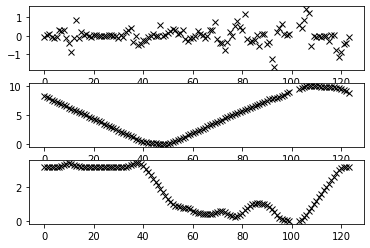

In [123]:
# Plot the control points
tan_derx, tan_dery = zip(*tangent_derivatives)

plt.subplot(3,1,1)
for i in range(trackPointCount):
    #if i % 2 == 0:
    #plt.plot(i, np.linalg.norm(tangent_derivatives[i]), 'kx')
    plt.plot(i, math.atan2(tangent_derivatives[i][1], tangent_derivatives[i][0]) * np.linalg.norm(tangent_derivatives[i]), 'kx')

plt.subplot(3,1,2)
for i in range(trackPointCount):
    plt.plot(i, px[i], 'kx')

plt.subplot(3,1,3)
for i in range(trackPointCount):
    plt.plot(i, py[i], 'kx')

plt.show()